# Imports

In [1]:
import os

import numpy as np
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
from scipy.signal import savgol_filter
import mlflow
from mlflow.tracking import MlflowClient
from dotenv import load_dotenv

from src.datasets import SurveillanceAnomalyDataset, load_UCSD_labels
from src.hstgcnn import KnowledgeHSTGCNN
from src.datasets import normalize_scores, reduce_to_regions
from visualize import plot_anomaly_scores, plot_roc_curve


load_dotenv()

True

# Load data

In [2]:
data_path = "../data"
test_set_base = "UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/"
gt_filename = "UCSDped2.m"

## Load labels

In [3]:
gt_path = os.path.join(data_path, test_set_base, gt_filename)
video_lens = [180, 180, 150, 180, 150, 180, 180, 180, 120, 150, 180, 180]
labels = load_UCSD_labels(gt_path, video_lens)  # [n_videos, video_len]

## Load test set

In [4]:
dataset_path = os.path.join(data_path, "processed", test_set_base)
BATCH_SIZE = 32
num_workers = 4

test_set = SurveillanceAnomalyDataset(dataset_path)
test_set = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# Evaluate

## Make predictions

In [5]:
checkpoint_path = "../checkpoints/UCSD_Ped2/KnowledgeHSTGCNN_v350-epoch_16.ckpt"
DEVICE = "mps"

model = KnowledgeHSTGCNN.load_from_checkpoint(checkpoint_path)
model.to(DEVICE)
model.eval()

KnowledgeHSTGCNN(
  (high_level_stgcnn): STGCNN(
    (gcn): GCNConv(2, 32)
    (activation): PReLU(num_parameters=1)
  )
  (low_level_stgcnn): STGCNN(
    (gcn): GCNConv(2, 64)
    (activation): PReLU(num_parameters=1)
  )
  (feature_fusion): KnowledgeFeatureFusion(
    (gnn1): GCNConv(384, 32)
    (gnn2): GCNConv(32, 32)
    (query_projection): Linear(in_features=96, out_features=32, bias=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (fusion): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
    )
  )
  (ffp): FFP(
    (shared_backbone): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): PReLU(num_parameters=1)
      (2): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (3): PReLU(num_parameters=1)
      (4): Conv2d(128, 128, kernel_size=(3, 1), stride=(1

In [6]:
anomaly_scores = []
for batch in tqdm(test_set, desc=f"Predicting {test_set_base}"):
    batch = {
        k: v.to(DEVICE) if torch.is_tensor(v) else v
        for k, v in batch.items()
    }
    with torch.no_grad():
        score = model.predict(batch)
    score = score.detach().cpu().numpy()
    anomaly_scores += list(score)

## Index predicted frames

In [9]:
frame_numbers = [list(sample[-1]["frame_idx"])[-1] for sample in test_set.dataset.samples]

frames_per_video = []
video_frames = []
for i, frame_idx in enumerate(frame_numbers[:-1]):
    video_frames.append(frame_idx)
    next_frame_idx = frame_numbers[i+1]
    if frame_idx > next_frame_idx:
        frames_per_video.append(video_frames)
        video_frames = []
# Add last frame index and last video indices
video_frames.append(next_frame_idx)
frames_per_video.append(video_frames)

## Match labels with predictions

In [18]:
extracted_labels = [
    labels[i][np.array(frames) - 1]  # Video frames are 1-index
    for i, frames in enumerate(frames_per_video)
]

## Normalize predictions

In [12]:
normalized_scores = []
processed_frames = 0
for video_labels in extracted_labels:
    new_frames = len(video_labels)
    if processed_frames > len(anomaly_scores):
        break
    scores = normalize_scores(anomaly_scores[processed_frames: processed_frames + new_frames])
    normalized_scores.append(scores)
    processed_frames += new_frames

In [14]:
reduced_labels, reduced_preds = [], []
for i in range(len(extracted_labels)):
    y_true, y_pred = reduce_to_regions(extracted_labels[i], normalized_scores[i])
    reduced_labels.append(y_true)
    reduced_preds.append(y_pred)

## Visualize

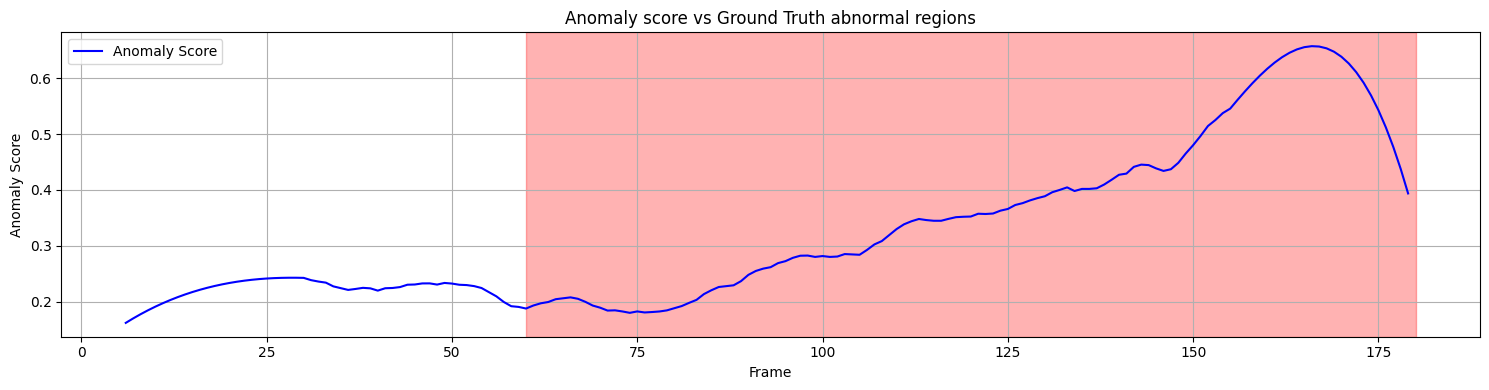

In [24]:
i = 0
window_size = 50
polynomial_order = 3
scores_curve = savgol_filter(normalized_scores[i][..., 0], window_size, polynomial_order)
anomaly_score_figure = plot_anomaly_scores(extracted_labels[i], scores_curve)

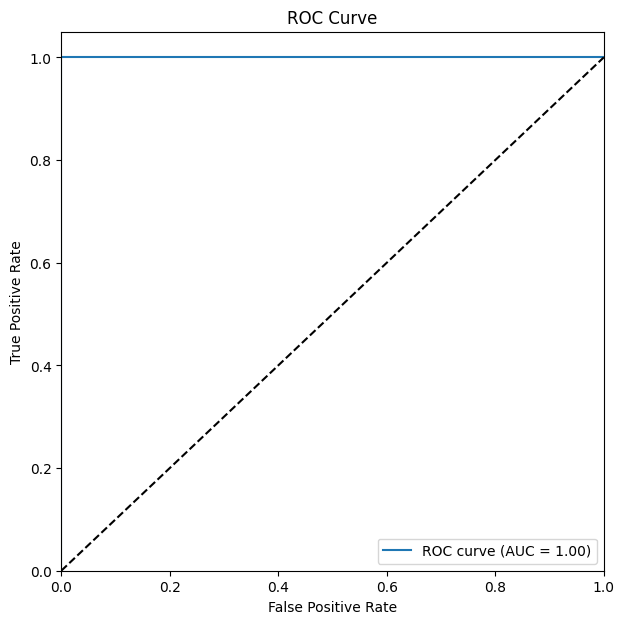

In [26]:
roc_curve_fig, roc_auc = plot_roc_curve(np.concatenate(reduced_labels), np.concatenate(reduced_preds))

## Log metrics

In [27]:
client = MlflowClient()

experiment_name = "HSTGCNN_UCSD_Ped2"
run_id = "ed2c307ccb85439a92de41826eea9c68"

mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/oleksandr/Documents/Studies/put-ai/MSc/thesis/GBADiS/mlruns/849674960412173287', creation_time=1750715910856, experiment_id='849674960412173287', last_update_time=1750715910856, lifecycle_stage='active', name='HSTGCNN_UCSD_Ped2', tags={}>

In [29]:
client.log_figure(run_id, anomaly_score_figure, "figures/anomaly_score_graph.png")

In [30]:
client.log_figure(run_id, roc_curve_fig, "figures/roc_auc.png")

In [31]:
client.log_metric(run_id, "roc_auc", roc_auc)